# Driverless AI (1.8.4.1): Using the Python API
This notebook provides an H2OAI Client workflow, of model building and scoring, that parallels the Driverless AI workflow.

## Notes:

* The following code was built for DAI Version 1.8.4.1.
* Python 3.6 is the only supported version.
* You must install the `h2oai_client` wheel to your local Python. This is available from the RESOURCES link in the top menu of the UI.

![py-client](h2oai_client_images/py_client_link.png)

# Workflow Steps

**Build an Experiment with Python API:**

1. Sign in
2. Exploratory Analysis
3. Split data into train & test set
4. Specify experiment parameters
5. Launch Experiement
6. Examine Experiment
7. Download Predictions
    
**Build an Experiment in Web UI and Access Through Python:**

1. Get pointer to experiment
    
**Score on New Data:**

1. Score on new data with H2OAI model

**Model Diagnostics on New Data:**

1. Run model diagnostincs on new data with H2OAI model

**Run Model Interpretation**

1. Run model interpretation on the raw features
2. Run Model Interpretation on External Model Predictions

**Build Scoring Pipelines**

1. Build Python Scoring Pipeline
2. Build MOJO Scoring Pipeline

# Build an Experiment with Python API

### 1. Sign In

Import the required modules and log in.

Pass in your credentials through the Client class which creates an authentication token to send to the Driverless AI Server. In plain English: to sign into the Driverless AI web page (which then sends requests to the Driverless Server), instantiate the Client class with your Driverless AI address and login credentials.

In [1]:
import h2oai_client
import numpy as np
import pandas as pd
import requests
import math
import re
import os
from h2oai_client import Client, ModelParameters, InterpretParameters
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# provide address, username, and password
# make sure to use the same user name and password when signing in through the GUI
address = 'http://ec2-52-90-34-74.compute-1.amazonaws.com:12345'
username = ''
password = ''
dai = Client(address = address, username = username, password = password)

In [3]:
### IMPORTANT: make sure that the Python client version is the same as the DAI backend that you're connecting to.
### If not, make sure to download and install the Python client from the DAI version that you're using.
print(h2oai_client.__version__)

1.8.4.1


#### Equivalent Steps in Driverless: Signing In
![Equivalent Steps in Driverless: Signing In](h2oai_client_images/sign_in_home_page_0.png)

![Equivalent Steps in Driverless: Signing In](h2oai_client_images/heart_disease_datafull.png)

### 2. Exploratory Analysis

For the following code, it is assumed that the full data are already loaded into DAI.

##### Note that once a data set is loaded into or created in DAI, you will typically reference that data by its KEY. 

In [4]:
### Structure of data storage in DAI
dai.list_datasets(offset=0, limit=10, include_inactive=False).dump()

{'datasets': [{'key': '18551c7a-7f54-11ea-851a-0242ac110002',
   'name': 'cleveland_heart_encoded.csv',
   'file_path': './tmp/18551c7a-7f54-11ea-851a-0242ac110002/cleveland_heart_encoded.csv.1586980975.3127205.bin',
   'file_size': 13632,
   'data_source': 'upload',
   'row_count': 303,
   'column_count': 19,
   'import_status': 0,
   'import_error': '',
   'aggregation_status': -1,
   'aggregation_error': '',
   'aggregated_frame': '',
   'mapping_frame': '',
   'uploaded': True}],
 'offset': 0,
 'limit': 10,
 'total_count': 1}

In [5]:
for d in dai.list_datasets(offset=0, limit=10, include_inactive=False).datasets:
    print(d.key + "\t" + str(round((d.file_size / 1000000000), 1)) + "GB\t" + d.name)

18551c7a-7f54-11ea-851a-0242ac110002	0.0GB	cleveland_heart_encoded.csv


In [6]:
for d in dai.list_datasets(offset=0, limit=10, include_inactive=False).datasets:
    if d.name == "cleveland_heart_encoded.csv":
        full_data_key = d.key 
        
full_data_key

'18551c7a-7f54-11ea-851a-0242ac110002'

In [7]:
dat = dai.create_csv_from_dataset(full_data_key)
finished_dat = dai.get_create_csv_job(dat)
# path needs to match expectation of _download
path = re.sub("^/files/", "", finished_dat.url)
local_path = dai.download(path, '.')
dat_full = pd.read_csv(local_path)
dat_full.head()

,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,male,cp_asymptomatic,cp_atypticalAngina,cp_typicalAngina,restECG_LVH,restECG_normal,slope_flat,slope_upsloping,thal_fixedDefect,thal_reversableDefect
0,63,145,233,1,150,0,2.3,2.0,0,1,0,0,1,1,0,0,0,1.0,0.0
1,67,160,286,0,108,1,1.5,5.0,1,1,1,0,0,1,0,1,0,0.0,0.0
2,67,120,229,0,129,1,2.6,4.0,1,1,1,0,0,1,0,1,0,0.0,1.0
3,37,130,250,0,187,0,3.5,2.0,0,1,0,0,0,0,1,0,0,0.0,0.0
4,41,130,204,0,172,0,1.4,2.0,0,0,0,1,0,1,0,0,1,0.0,0.0


In [8]:
dat_full.describe()

,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,male,cp_asymptomatic,cp_atypticalAngina,cp_typicalAngina,restECG_LVH,restECG_normal,slope_flat,slope_upsloping,thal_fixedDefect,thal_reversableDefect
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,301.000000,301.000000
mean,54.438944,131.689769,246.693069,0.148515,149.607261,0.326733,1.039604,2.672241,0.458746,0.679868,0.475248,0.165017,0.075908,0.488449,0.498350,0.462046,0.468647,0.059801,0.388704
std,9.038662,17.599748,51.776918,0.356198,22.875003,0.469794,1.161075,0.937438,0.499120,0.467299,0.500213,0.371809,0.265288,0.500693,0.500824,0.499382,0.499842,0.237512,0.488268
min,29.000000,94.000000,126.000000,0.000000,71.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,0.000000,133.500000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,130.000000,241.000000,0.000000,153.000000,0.000000,0.800000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,140.000000,275.000000,0.000000,166.000000,1.000000,1.600000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,77.000000,200.000000,564.000000,1.000000,202.000000,1.000000,6.200000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Equivalent Steps in Driverless: Data Details
![Equivalent Steps in Driverless: Data Detail](h2oai_client_images/heart_disease_details.png)

#### Create DAI visualization manually:
http://docs.h2o.ai/driverless-ai/1-8-lts/docs/userguide/examples/autoviz_client_example/autoviz_client_example.html#

In [9]:
hist = dai.autoviz.get_histogram(full_data_key, variable_name='age')
scatterplot = dai.autoviz.get_scatterplot(full_data_key, x_variable_name='age', y_variable_name='thalach')

In [10]:
from vega import VegaLite

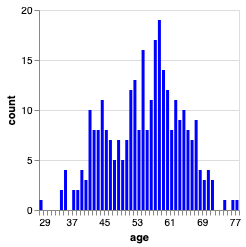

In [11]:
# to view plots inline, installation of https://github.com/vega/ipyvega may be required
VegaLite(hist)

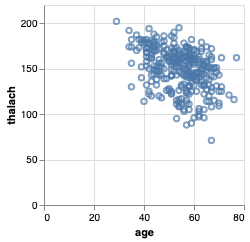

In [12]:
VegaLite(scatterplot)

### 3. Split Data into Training and Test Data Sets

In [13]:
split = dai.make_dataset_split_sync(dataset_key=full_data_key, 
                                    output_name1="heart_train", 
                                    output_name2="heart_test", 
                                    target="target", 
                                    fold_col=None, 
                                    time_col=None, 
                                    ratio=0.7, 
                                    seed=1234)

In [14]:
print(split)

train_key = split[0]
test_key = split[1]

['2c1255ac-7f59-11ea-851a-0242ac110002', '2c13eb92-7f59-11ea-851a-0242ac110002']


In [15]:
splits = list()
for i in split:
    
    # Make a csv file that can be read in pandas easily
    job = dai.create_csv_from_dataset(i)
    finished_job = dai.get_create_csv_job(job)
    
    
    # path needs to match expectation of _download
    path = re.sub("^/files/", "", finished_job.url)
    print(path)
    
    local_path = dai.download(path, '.')
    print(local_path)
    
    df = pd.read_csv(local_path)
    df.head()
    splits.append(df)

2c1255ac-7f59-11ea-851a-0242ac110002/heart_train.1586983155.8528652.csv
./heart_train.1586983155.8528652.csv
2c13eb92-7f59-11ea-851a-0242ac110002/heart_test.1586983155.8688304.csv
./heart_test.1586983155.8688304.csv


In [16]:
train = splits[0]
test = splits[1]

display(train.head())
display(test.head())

,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,male,cp_asymptomatic,cp_atypticalAngina,cp_typicalAngina,restECG_LVH,restECG_normal,slope_flat,slope_upsloping,thal_fixedDefect,thal_reversableDefect
0,63,108,269,0,169,1,1.8,4.0,1,0,1,0,0,0,1,1,0,0.0,0.0
1,40,110,167,0,114,1,2.0,2.0,1,1,1,0,0,1,0,1,0,0.0,1.0
2,51,140,308,0,142,0,1.5,3.0,0,0,0,0,0,1,0,0,1,0.0,0.0
3,46,150,231,0,147,0,3.6,2.0,1,1,0,0,0,0,1,1,0,0.0,0.0
4,66,150,226,0,114,0,2.6,2.0,0,0,0,0,1,0,1,0,0,0.0,0.0


,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,male,cp_asymptomatic,cp_atypticalAngina,cp_typicalAngina,restECG_LVH,restECG_normal,slope_flat,slope_upsloping,thal_fixedDefect,thal_reversableDefect
0,61,150,243,1,137,1,1.0,2.0,0,1,0,0,0,0,1,1,0,0,0
1,54,150,232,0,165,0,1.6,2.0,0,1,0,0,0,1,0,0,1,0,1
2,46,120,249,0,144,0,0.8,2.0,1,1,1,0,0,1,0,0,1,0,1
3,44,110,197,0,177,0,0.0,3.0,1,1,1,0,0,1,0,0,1,0,0
4,48,130,245,0,180,0,0.2,2.0,0,1,0,1,0,1,0,1,0,0,0


#### Equivalent Steps in Driverless: Creating Train & Test Data Files
![Equivalent Steps in Driverless: Creating Train & Test Data Files](h2oai_client_images/heart_disease_testtrain.png)

### 4. Set Experiment Parameters

We will now set the parameters of our experiment.  Some of the parameters include:

* Target Column: The column we are trying to predict.
* Dropped Columns: The columns we do not want to use as predictors such as ID columns, columns with data leakage, etc.
* Weight Column: The column that indicates the per row observation weights. If `None`, each row will have an observation weight of 1.
* Fold Column: The column that indicates the fold. If `None`, the folds will be determined by Driverless AI.
* Is Time Series: Whether or not the experiment is a time-series use case.

For information on the experiment settings, refer to the [Experiment Settings](http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/running-experiment.html#experiment-settings).

For this example, we will be predicting **`the presence of heart disease`**.  The parameters that control the experiment process are: `accuracy`, `time`, and `interpretability`.  We can use the `get_experiment_preview_sync` function to get a sense of what will happen during the experiment.  

We will start out by seeing what the experiment will look like with `accuracy`, `time`, and `interpretability` all set to 5.

In [17]:
exp_preview = dai.get_experiment_preview_sync(dataset_key = train_key, 
                                              resumed_experiment_id = '',
                                              validset_key='', 
                                              classification=True, 
                                              dropped_cols = [], 
                                              target_col='target', 
                                              is_time_series = False, 
                                              time_col='',
                                              enable_gpus = True, 
                                              accuracy = 5, 
                                              time = 5, 
                                              interpretability = 5, 
                                              reproducible = False,
                                              config_overrides = None)
exp_preview

['ACCURACY [5/10]:',
 '- Training data size: *212 rows, 19 cols*',
 '- Feature evolution: *[Constant, LightGBM, XGBoostGBM]*, *1/3 validation split**, 2 reps*',
 '- Final pipeline: *Ensemble (6 models), 3-fold CV*',
 '',
 'TIME [5/10]:',
 '- Feature evolution: *4 individuals*, up to *66 iterations*',
 '- Early stopping: After *10* iterations of no improvement',
 '',
 'INTERPRETABILITY [5/10]:',
 '- Feature pre-pruning strategy: None',
 '- Monotonicity constraints: disabled',
 '- Feature engineering search space: [CVCatNumEncode, CVTargetEncode, CatOriginal, Cat, ClusterDist, ClusterTE, Frequent, Interactions, NumCatTE, NumToCatTE, NumToCatWoE, Original, TruncSVDNum, WeightOfEvidence]',
 '',
 '[Constant, LightGBM, XGBoostGBM] models to train:',
 '- Model and feature tuning: *32*',
 '- Feature evolution: *208*',
 '- Final pipeline: *6*',
 '',
 'Estimated runtime: *minutes*',
 'Auto-click Finish/Abort if not done in: *1 day*/*7 days*']

With these settings, the Driverless AI experiment will train about 246 models: 
* 32 for model and feature tuning
* 208 for feature evolution
* 6 for the final pipeline

When we start the experiment, we can either: 

* specify parameters
* use Driverless AI to suggest parameters

Driverless AI can suggest the parameters based on the dataset and target column.  Below we will use the **`get_experiment_tuning_suggestion`** to see what settings Driverless AI suggests.

In [18]:
# let Driverless suggest parameters for experiment
params = dai.get_experiment_tuning_suggestion(dataset_key = train_key, 
                                                target_col = 'target', 
                                                is_classification = True, 
                                                is_time_series = False,
                                                config_overrides = None,
                                                cols_to_drop = [])

In [19]:
params.dump()

{'dataset': {'key': '2c1255ac-7f59-11ea-851a-0242ac110002',
  'display_name': ''},
 'resumed_model': {'key': '', 'display_name': ''},
 'target_col': 'target',
 'weight_col': '',
 'fold_col': '',
 'orig_time_col': '',
 'time_col': '',
 'is_classification': True,
 'cols_to_drop': [],
 'validset': {'key': '', 'display_name': ''},
 'testset': {'key': '', 'display_name': ''},
 'enable_gpus': True,
 'seed': False,
 'accuracy': 7,
 'time': 2,
 'interpretability': 8,
 'score_f_name': 'AUC',
 'time_groups_columns': [],
 'unavailable_columns_at_prediction_time': [],
 'time_period_in_seconds': None,
 'num_prediction_periods': None,
 'num_gap_periods': None,
 'is_timeseries': False,
 'cols_imputation': [],
 'config_overrides': None}

Driverless AI has found that the best parameters are to set **`accuracy = 7`**, **`time = 2`**, **`interpretability = 8`**. It has selected **`AUC`** as the scorer (this is the default scorer for binomial problems).  

#### Equivalent Steps in Driverless: Set the Knobs, Configuration & Launch
![Equivalent Steps in Driverless: Set the Knobs](h2oai_client_images/heart_disease_setup.png)

### 5. Launch Experiment: Feature Engineering + Final Model Training

Launch the experiment using the parameters that Driverless AI suggested along with the testset, scorer, and seed that were added. We can launch the experiment with the suggested parameters or create our own.

In [20]:
experiment = dai.start_experiment_sync(dataset_key=train_key,
                                         testset_key = test_key,
                                         target_col='target',
                                         experiment_name = "Heart Default",
                                         is_classification=True,
                                         accuracy=7,
                                         time=2,
                                         interpretability=8,
                                         scorer="AUC",
                                         enable_gpus=True,
                                         seed=1234,
                                         cols_to_drop=['ID'])

#### Equivalent Steps in Driverless: Launch Experiment

![Equivalent Steps in Driverless: Launch Your Experiment](h2oai_client_images/heart_disease_experiment.png)

![Equivalent Steps in Driverless: Launch Your Experiment](h2oai_client_images/heart_disease_experimentlist.png)

### 6. Examine Experiment

View the final model score for the validation and test datasets. When feature engineering is complete, an ensemble model can be built depending on the accuracy setting. The experiment object also contains the score on the validation and test data for this ensemble model.  In this case, the validation score is the score on the training cross-validation predictions.

In [21]:
print("Final Model Score on Validation Data: " + str(round(experiment.valid_score, 3)))
print("Final Model Score on Test Data: " + str(round(experiment.test_score, 3)))

Final Model Score on Validation Data: 0.923
Final Model Score on Test Data: 0.928


The experiment object also contains the scores calculated for each iteration on bootstrapped samples on the validation data.  In the iteration graph in the UI, we can see the mean performance for the best model (yellow dot) and +/- 1 standard deviation of the best model performance (yellow bar).

This information is saved in the experiment object.

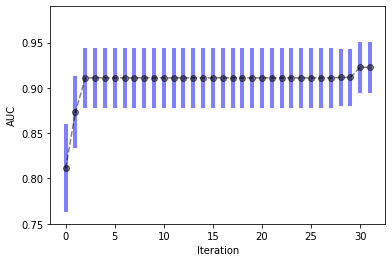

In [22]:
# Add scores from experiment iterations
iteration_data = dai.list_model_iteration_data(experiment.key, 0, len(experiment.iteration_data))
iterations = list(map(lambda iteration: iteration.iteration, iteration_data))
scores_mean = list(map(lambda iteration: iteration.score_mean, iteration_data))
scores_sd = list(map(lambda iteration: iteration.score_sd, iteration_data))

# Add score from final ensemble
iterations = iterations + [max(iterations) + 1]
scores_mean = scores_mean + [experiment.valid_score]
scores_sd = scores_sd + [experiment.valid_score_sd]

plt.figure()
plt.errorbar(iterations, scores_mean, yerr=scores_sd, color = "black", 
             ecolor='blue', fmt = '--o', elinewidth = 4, alpha = 0.5)
plt.xlabel("Iteration")
plt.ylabel("AUC")
plt.ylim([0.75, 0.99])
plt.show();

#### Equivalent Steps in Driverless: View Results
![Equivalent Steps in Driverless: View Results](h2oai_client_images/heart_disease_experimentcomplete.png)

### 7. Download Results

Once an experiment is complete, we can see that the UI presents us options of downloading the: 

* predictions 
    * on the (holdout) train data
    * on the test data
* experiment summary - summary of the experiment including feature importance

We will show an example of downloading the test predictions below.  Note that equivalent commands can also be run for downloading the train (holdout) predictions. 

In [23]:
dai.download(src_path=experiment.test_predictions_path, dest_dir=".")

'./test_preds.csv'

In [24]:
test_preds = pd.read_csv("./test_preds.csv")
test_preds.head()

,target.0,target.1
0,0.562779,0.437221
1,0.633355,0.366645
2,0.483704,0.516296
3,0.498206,0.501794
4,0.641321,0.358679


We can also download and examine the summary of the experiment and feature importance for the final model.

In [25]:
# Download Summary
import subprocess
summary_path = dai.download(src_path=experiment.summary_path, dest_dir=".")
dir_path = "./h2oai_experiment_summary_" + experiment.key
subprocess.call(['unzip', '-o', summary_path, '-d', dir_path], shell=False)

0

The table below shows the feature name, its relative importance, and a description.  Some features will be engineered by Driverless AI and some can be the original feature.

In [26]:
# View Features
features = pd.read_table(dir_path + "/ensemble_features.txt", sep=',', skipinitialspace=True)
features.head(n = 10)

,Relative Importance,Standard Deviation of Relative Importance,Description,Feature
0,1.000000,0.114596,Weight of Evidence for columns ['cp_asymptomat...,46_NumToCatWoEMonotonic:cp_asymptomatic:male:s...
1,0.949466,0.216673,ca (Orig),1_ca
2,0.594306,0.423157,thal_reversableDefect (Orig),15_thal_reversableDefect
3,0.530057,0.633253,Weight of Evidence for columns ['cp_asymptomat...,41_NumToCatWoEMonotonic:cp_asymptomatic:thal_r...
4,0.458311,0.241217,"Weight of Evidence for columns ['male', 'slope...",61_WoE:male:slope_flat.0
5,0.419117,0.323581,cp_asymptomatic (Orig),3_cp_asymptomatic
6,0.397513,0.100315,Out-of-fold mean of the response grouped by: [...,19_CVTE:ca.0
7,0.331183,0.267646,oldpeak (Orig),9_oldpeak
8,0.323767,0.309171,Out-of-fold mean of the response grouped by: [...,30_CVTE:slope_flat.0
9,0.317187,0.096203,thalach (Orig),16_thalach


# Score on New Data

You can use the Python API to score on new data. This is equivalent to the **SCORE ON ANOTHER DATASET** button in the Web UI. The example below scores on the test data and then downloads the predictions.

Pass in any dataset that has the same columns as the original training set. If you passed a test set during the H2OAI model building step, the predictions already exist. Its path can be found with **`experiment.test_predictions_path`**.

### Score Using the DAI Model

The following shows the predicted probability of default for each record in the test data set.  

In [27]:
prediction = dai.make_prediction_sync(experiment.key, test_key, output_margin = False, pred_contribs = False)
pred_path = dai.download(prediction.predictions_csv_path, '.')
pred_table = pd.read_csv(pred_path)
pred_table.head()

,target.0,target.1
0,0.562779,0.437221
1,0.633355,0.366645
2,0.483704,0.516296
3,0.498206,0.501794
4,0.641321,0.358679


We can also get the contribution each feature had to the final prediction by setting `pred_contribs = True`.  This will give us an idea of how each feature effects the predictions. 

In [28]:
prediction_contributions = dai.make_prediction_sync(experiment.key, test_key, 
                                                      output_margin = False, pred_contribs = True)
pred_contributions_path = dai.download(prediction_contributions.predictions_csv_path, '.')
pred_contributions_table = pd.read_csv(pred_contributions_path)
pred_contributions_table.head()

,contrib_0_age,contrib_12_slope_flat,contrib_13_slope_upsloping,contrib_15_thal_reversableDefect,contrib_16_thalach,contrib_17_trestbps,contrib_18_CVTE:age.0,contrib_19_CVTE:ca.0,contrib_1_ca,contrib_20_CVTE:chol.0,...,contrib_53_NumToCatWoEMonotonic:thal_reversableDefect.0,contrib_54_CVCatNumEnc:cp_asymptomatic:exang:male:trestbps:age.sd,contrib_54_CVCatNumEnc:cp_asymptomatic:exang:male:trestbps:oldpeak.sd,contrib_54_CVCatNumEnc:cp_asymptomatic:exang:male:trestbps:thalach.sd,contrib_55_NumCatTE:age:ca:chol:cp_asymptomatic:oldpeak:thalach:trestbps.0,contrib_61_WoE:male:slope_flat.0,contrib_62_WoE:age:cp_asymptomatic:exang.0,contrib_6_exang,contrib_9_oldpeak,contrib_bias
0,0.059772,0.003617,0.031683,-0.035059,0.123659,0.030040,-0.008515,-0.128374,-0.192757,-0.004942,...,-0.031740,-0.012583,-0.014139,-0.007986,0.001711,0.089271,-0.004208,0.172728,0.013374,-0.264725
1,-0.034524,-0.003139,-0.020268,0.062465,-0.071889,0.022171,-0.000723,-0.076798,-0.130289,-0.004522,...,0.065465,-0.022440,0.031938,-0.044975,-0.006245,-0.016259,-0.025153,-0.091827,0.004943,-0.264725
2,-0.042329,-0.003139,-0.014536,0.095490,-0.054157,-0.002169,-0.000635,-0.125750,-0.214561,-0.002689,...,0.065019,-0.015114,0.006467,0.017746,-0.008727,-0.004679,-0.004053,-0.098143,0.005057,-0.264725
3,-0.059517,-0.009948,-0.011939,-0.017012,-0.089541,-0.013388,0.013594,0.176514,0.355231,-0.002066,...,-0.010277,-0.011613,0.004013,-0.009045,-0.002268,-0.001622,0.001147,-0.057760,-0.099302,-0.264725
4,-0.052700,0.002930,0.020609,-0.022650,-0.078971,-0.001974,-0.001734,-0.131987,-0.222730,-0.005201,...,-0.023965,0.035767,0.027956,0.001168,0.004363,0.095481,-0.005693,-0.075029,-0.076591,-0.264725


# Run Model Interpretation

Once we have completed an experiment, we can interpret our H2OAI model.  Model Interpretability is used to provide model transparency and explanations.  More information on Model Interpretability can be found here: http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/interpreting.html.


### Run Model Interpretation on the Raw Data

We can run the model interpretation in the Python client as shown below.  By setting the parameter, `use_raw_features` to True, we are interpreting the model using only the raw features in the data.  This will not use the engineered features we saw in our final model's features to explain the data.  

In [29]:
mli_experiment = dai.run_interpretation_sync(dai_model_key = experiment.key,
                                               dataset_key = train_key,
                                               target_col = 'target',
                                               use_raw_features = True)

This is equivalent to clicking **Interpet this Model** in the UI once the experiment has completed.

![Equivalent Steps in Driverless: View Results](h2oai_client_images/heart_disease_MLI.png)

Once our interpretation is finished, we can navigate to the MLI tab in the UI to see our interpreted model. 

![Equivalent Steps in Driverless: MLI List](h2oai_client_images/heart_disease_MLIlist.png)

We can also see the list of interpretations using the Python Client:

In [30]:
# Get list of interpretations
mli_list = list(map(lambda x: x.key, dai.list_interpretations(offset=0, limit=100)))
mli_list

['aa5d1fa4-7f5a-11ea-851a-0242ac110002']

# Use shap package to view Shapley values

##### Note that approach to obtaining Shapley values for original features (and not transformed features) requires downloading Shapley value to file and then reading in data file.

In [31]:
# For shap library
#https://github.com/slundberg/shap

import shap

In [32]:
# Shapley values for transformed features
contributions_matrix = pred_contributions_table.values
shap_transformed = contributions_matrix[:,:-1]

In [33]:
# Shapley values for original features
mli_key = mli_list[0]
mli = dai.get_interpretation_job(mli_key).entity
original_shap_path = os.path.join(mli.tmp_dir, "shapley.orig.feat.csv")
original_shap_path = re.sub('^./tmp/', '', original_shap_path)
dai.download(original_shap_path, '.')
shap_original = pd.read_csv("shapley.orig.feat.csv")
shap_original = shap_original.drop(['bias'],axis=1)

In [34]:
# predictor variables only
train_x = train.drop(['target'],axis=1)
# sort columns in train_x to match column order of shap_original
train_x = train_x[shap_original.columns.tolist()]
# convert shap_original to np array
shap_original = shap_original.values

### summarize the effects of all the features

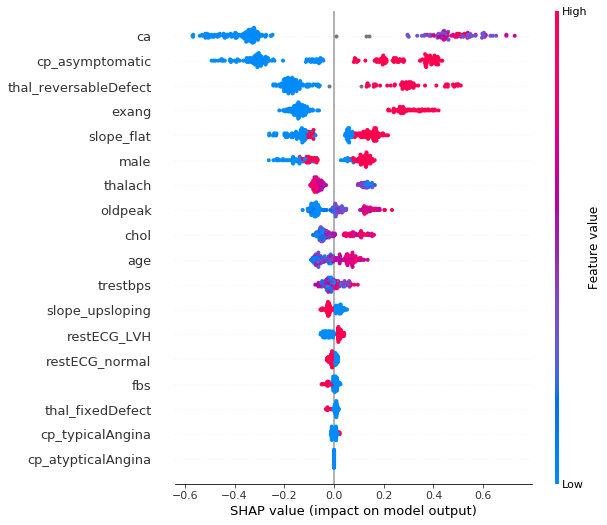

In [35]:
shap.summary_plot(shap_original, train_x)

### create a dependence plot to show the effect of a single feature across the whole dataset

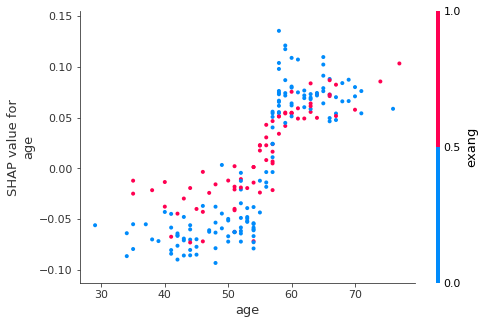

In [36]:
shap.dependence_plot("age", shap_original, train_x)

### bar plot of the mean absolute value of the SHAP values

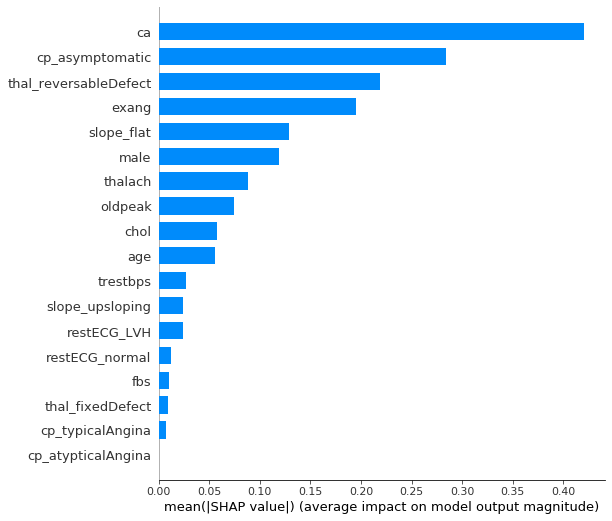

In [37]:
shap.summary_plot(shap_original, train_x, plot_type="bar")

# Build Scoring Pipelines

In our last section, we will build the scoring pipelines from our experiment.  There are two scoring pipeline options: 

* Python Scoring Pipeline: requires Python runtime
* MOJO Scoring Pipeline: requires Java runtime

Documentation on the scoring pipelines is provided here: http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/python-mojo-pipelines.html.

![Equivalent Steps in Driverless: View Results](h2oai_client_images/heart_disease_experimentcomplete.png)

The experiment screen shows two scoring pipeline buttons: **Download Python Scoring Pipeline** or **Build MOJO Scoring Pipeline**.  Driverless AI determines if any scoring pipeline should be automatically built based on the config.toml file.  In this example, we have run Driverless AI with the settings: 

```
# Whether to create the Python scoring pipeline at the end of each experiment
make_python_scoring_pipeline = true

# Whether to create the MOJO scoring pipeline at the end of each experiment
# Note: Not all transformers or main models are available for MOJO (e.g. no gblinear main model)
make_mojo_scoring_pipeline = false
```

Therefore, only the Python Scoring Pipeline will be built by default.

### 1. Build Python Scoring Pipeline

The Python Scoring Pipeline has been built by default based on our config.toml settings.  We can get the path to the Python Scoring Pipeline in our experiment object.

In [38]:
experiment.scoring_pipeline_path

'h2oai_experiment_358d2bf2-7f59-11ea-851a-0242ac110002/scoring_pipeline/scorer.zip'

We can also build the Python Scoring Pipeline - this is useful if the **`make_python_scoring_pipeline`** option was set to false.

In [39]:
python_scoring_pipeline = dai.build_scoring_pipeline_sync(experiment.key)

In [40]:
python_scoring_pipeline.file_path

'h2oai_experiment_358d2bf2-7f59-11ea-851a-0242ac110002/scoring_pipeline/scorer.zip'

Now we will download the scoring pipeline zip file.

In [41]:
dai.download(python_scoring_pipeline.file_path, dest_dir=".")

'./scorer.zip'

### 2. Build MOJO Scoring Pipeline

The MOJO Scoring Pipeline has not been built by default because of our config.toml settings.  We can build the MOJO Scoring Pipeline using the Python client.  This is equivalent to selecting the **Build MOJO Scoring Pipeline** on the experiment screen.

In [42]:
mojo_scoring_pipeline = dai.build_mojo_pipeline_sync(experiment.key)

In [43]:
mojo_scoring_pipeline.file_path

'h2oai_experiment_358d2bf2-7f59-11ea-851a-0242ac110002/mojo_pipeline/mojo.zip'

Now we can download the scoring pipeline zip file.

In [44]:
dai.download(mojo_scoring_pipeline.file_path, dest_dir=".")

'./mojo.zip'

Once the MOJO Scoring Pipeline is built, the **Build MOJO Scoring Pipeline** changes to **Download MOJO Scoring Pipeline**.



![Equivalent Steps in Driverless: Download MOJO](h2oai_client_images/download_mojo.png)